<div align="center"> <h1> Section C: Training and Deploying with the AWS SageMaker </h1> </div>
<div align="center"> <h4>  Swastik Nath. </h4> </div>
<div align='center'> <h4> Udacity Machine Learning Engineer Nanodegree Final Capstone</h4> </div> 

<hr></hr>

In order to productionize the idea of the model to the real world, AWS SageMaker is a no-match to anything. In order to deploy the model to the real world, train and deploy with the AWS SageMaker will require an engineering workflow. 
### Importing the Necessary Libraries.

In [1]:
import pandas as pd
import boto3
import sagemaker
import os

### Getting Hold of the AWS SageMaker credentials, Role and Bucket.
The Current SageMaker Session running throughout this notebook and beyond will be much required to get hold of the underlying bucket, execution role and IAM specifics and specific permissions and privillages of the current user.

In [2]:
session = sagemaker.Session()
role = sagemaker.get_execution_role()
bucket = session.default_bucket()
bucket

'sagemaker-us-west-2-782510500637'

### Uploading to Datasets to S3: This may take significant amount of time because of Large Size of Data.
Clean up of the bucket mentioned above after training the model will be required not to incur additional charges on the AWS Bills or not to exceed the free tier or credits that have been applied to the AWS account. **Once Executed, do not execute it again, as it may incur additional charges. If needed to execute again, please clear the S3 bucket first.**

In [122]:
%%time
data_dir = 'data'
train_prefix = 'train_chest_xray/train'
test_prefix = 'test_chest_xray/test'
#uploading both of these two to S3 for Sagemaker Inference:
train_data = session.upload_data(os.path.join(data_dir, 'workdir'), key_prefix = train_prefix)
test_data = session.upload_data(os.path.join(data_dir, 'testdir'), key_prefix = test_prefix)

CPU times: user 54.5 s, sys: 7.15 s, total: 1min 1s
Wall time: 16min 8s


Checking whether the Dataset has been uploaded correctly or not. 

In [123]:
empty_check = []
for obj in boto3.resource('s3').Bucket(bucket).objects.all():
    empty_check.append(obj.key)
    print(obj.key)

assert len(empty_check) !=0, 'S3 bucket is empty.'

test_chest_xray/test/bacterial/BACTERIA-1135262-0001.jpeg
test_chest_xray/test/bacterial/BACTERIA-1135262-0002.jpeg
test_chest_xray/test/bacterial/BACTERIA-1135262-0003.jpeg
test_chest_xray/test/bacterial/BACTERIA-1135262-0004.jpeg
test_chest_xray/test/bacterial/BACTERIA-1220485-0001.jpeg
test_chest_xray/test/bacterial/BACTERIA-1351146-0001.jpeg
test_chest_xray/test/bacterial/BACTERIA-1351146-0002.jpeg
test_chest_xray/test/bacterial/BACTERIA-1351146-0003.jpeg
test_chest_xray/test/bacterial/BACTERIA-1351146-0004.jpeg
test_chest_xray/test/bacterial/BACTERIA-1351146-0005.jpeg
test_chest_xray/test/bacterial/BACTERIA-1351146-0006.jpeg
test_chest_xray/test/bacterial/BACTERIA-1514320-0001.jpeg
test_chest_xray/test/bacterial/BACTERIA-1514320-0002.jpeg
test_chest_xray/test/bacterial/BACTERIA-1514320-0003.jpeg
test_chest_xray/test/bacterial/BACTERIA-1602272-0001.jpeg
test_chest_xray/test/bacterial/BACTERIA-1602272-0002.jpeg
test_chest_xray/test/bacterial/BACTERIA-1602272-0003.jpeg
test_chest_xra

In [124]:
print(train_data)
print(test_data)

s3://sagemaker-us-west-2-782510500637/train_chest_xray/train
s3://sagemaker-us-west-2-782510500637/test_chest_xray/test


Once you upload the dataset use the printed the S3 Urls above to reference to the location through different kernel sessions. 

In [3]:
train_data = 's3://sagemaker-us-west-2-782510500637/train_chest_xray/train'
test_data = 's3://sagemaker-us-west-2-782510500637/test_chest_xray/test'

### Training the Model with the SageMaker PyTorch Estimator:
Now we train the model with SageMaker's PyTorch Estimator and pass in the location of the training dataset which is available via the **S3 Bucket** connected to this SageMaker Session. The url to the training data has been provided which will be downloaded in the training instance at the time of training and each of the image file will be passed through a cascade of **Torchvision Transformers** which will resize them and convert them to multidimensional tensors upon which our model can perform stochastic calculations, which will then be converted into Deterministic classification.  

**The training process below will require 30-45 minutes on CUDA and might take 2-3 hours on CPU to complete.**

### Training the VGG19 Batch Normalization:
As a base model we will be using VGG19 With Batch Normalization and will fit with our test data by providing the S3 location. We are using a **p2.xlarge** GPU powered EC2 ML instance to power the training process. We are referring to **train.py** available via **sagemaker_scripts** folder as our PyTorch Training Script.

In [125]:
from sagemaker.pytorch import PyTorch
model_prefix = 'chest_xray_model'
chest_xray_pyt = PyTorch(role = role, 
                         entry_point='train.py',
                         source_dir='sagemaker_scripts', 
                         train_instance_count=1,
                         train_instance_type = 'ml.p2.xlarge', 
                         sagemaker_session = session, 
                         framework_version='0.4.0',
                         hyperparameters={
                             'epochs':4,
                             'lr':0.001,
                             'batch-size':32
                         }
                        )                        

We fit the PyTorch Estimator object with the dataset location from S3 object storage as training and test dataset.

In [126]:
%%time
chest_xray_pyt.fit({'train':train_data, 'validation':test_data})

2020-04-13 19:38:30 Starting - Starting the training job...
2020-04-13 19:38:32 Starting - Launching requested ML instances......
2020-04-13 19:39:35 Starting - Preparing the instances for training......
2020-04-13 19:40:51 Downloading - Downloading input data............
2020-04-13 19:42:58 Training - Downloading the training image...
2020-04-13 19:43:19 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2020-04-13 19:43:19,941 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2020-04-13 19:43:19,966 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2020-04-13 19:43:22,991 sagemaker_pytorch_container.training INFO     Invoking user training script.
2020-04-13 19:43:23,303 sagemaker-containers INFO     Module train does not provide a setup.py. 
Generating setup.py
2020-04-13 19:43:23,303

If the Notebook gets out of sync with the AWS SageMaker Training job due to network error, we just retrieve the training job name from the AWS Management Console and put it into here, to pick up where we left off.

In [4]:
chest_xray_att = sagemaker.estimator.Estimator.attach(training_job_name='sagemaker-pytorch-2020-04-12-22-27-26-260')

2020-04-12 23:49:40 Starting - Preparing the instances for training
2020-04-12 23:49:40 Downloading - Downloading input data
2020-04-12 23:49:40 Training - Training image download completed. Training in progress.
2020-04-12 23:49:40 Uploading - Uploading generated training model
2020-04-12 23:49:40 Completed - Training job completedbash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2020-04-12 22:32:27,387 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2020-04-12 22:32:27,412 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2020-04-12 22:32:30,442 sagemaker_pytorch_container.training INFO     Invoking user training script.
2020-04-12 22:32:30,723 sagemaker-containers INFO     Module train does not provide a setup.py. 
Generating setup.py
2020-04-12 22:32:30,724 sagemaker-containers INFO     Generating setup.cfg
2020-04-12 22:32:30,724 sagemaker-conta

### Training the Resnet 50:

We will also be deploying a Restnet 50 based model and evaluate it's performance on the train and test dataset.

In [8]:
from sagemaker.pytorch import PyTorch
model_prefix = 'chest_xray_resnet_augmenter'
chest_xray_resnet_aug = PyTorch(role=role, 
                            entry_point='train_resnet.py',
                            source_dir = 'sagemaker_scripts', 
                            train_instance_count=1, 
                            train_instance_type='ml.p2.xlarge', 
                            sagemaker_session=session, framework_version='0.4.0',
                            hyperparameters={
                                'epochs': 3, 
                                'batch-size':64, 
                                 'lr':0.01
                            })

Fitting both the training and validation dataset.

In [ ]:
chest_xray_resnet_aug.fit({'train':train_data, 'validation':test_data})

2020-04-13 20:46:47 Starting - Starting the training job...
2020-04-13 20:46:49 Starting - Launching requested ML instances......
2020-04-13 20:47:53 Starting - Preparing the instances for training......
2020-04-13 20:49:16 Downloading - Downloading input data...............
2020-04-13 20:51:39 Training - Downloading the training image...
2020-04-13 20:52:13 Training - Training image download completed. Training in progress..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2020-04-13 20:52:14,750 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2020-04-13 20:52:14,775 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2020-04-13 20:52:17,797 sagemaker_pytorch_container.training INFO     Invoking user training script.
2020-04-13 20:52:18,182 sagemaker-containers INFO     Module train_resnet does not provide a setup.py. 
Generating setup.py
2020-04-13 2

If due to network error the notebook gets out of sync use the code below to attach the training job to the PyTorch Estimator.

In [12]:
chest_resnet = chest_xray_resnet_aug.attach(training_job_name='sagemaker-pytorch-2020-04-13-20-46-47-700', sagemaker_session=session)

2020-04-13 21:18:42 Starting - Preparing the instances for training
2020-04-13 21:18:42 Downloading - Downloading input data
2020-04-13 21:18:42 Training - Training image download completed. Training in progress.
2020-04-13 21:18:42 Uploading - Uploading generated training model
2020-04-13 21:18:42 Completed - Training job completedbash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2020-04-13 20:52:14,750 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2020-04-13 20:52:14,775 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2020-04-13 20:52:17,797 sagemaker_pytorch_container.training INFO     Invoking user training script.
2020-04-13 20:52:18,182 sagemaker-containers INFO     Module train_resnet does not provide a setup.py. 
Generating setup.py
2020-04-13 20:52:18,182 sagemaker-containers INFO     Generating setup.cfg
2020-04-13 20:52:18,183 sagemake

## Deployment Section:
We now implement Data Capture Configuration for our endpoint to capture 70% of the data being fed to the model and saves it to the specified bucket location so that we can actually capture data from the users and can use that data later to update our model later. 

In [45]:
# Creating provisions for Automatic Data Capture :
from time import gmtime, strftime
prefix = 'auto_data_capture'
data_capture_prefix = '{}/datacapture'.format(prefix)
s3_capture_upload_path = 's3://{}/{}'.format(bucket, data_capture_prefix)
reports_prefix = '{}/reports'.format(prefix)
s3_report_path = 's3://{}/{}'.format(bucket,reports_prefix)

from sagemaker.model_monitor import DataCaptureConfig
endpoint_name = 'chest-xray-with-data-capt-'+strftime("%Y-%m-%d-%H-%M-%S", gmtime())

data_capture_config = DataCaptureConfig(enable_capture=True, 
                                        sampling_percentage=70, 
                                        destination_s3_uri=s3_capture_upload_path)

#### Deploying the VGG19 Model

In [133]:
%%time
predictor = chest_xray_pyt.deploy(initial_instance_count=1,
                                  instance_type='ml.m4.xlarge')

-----------------!CPU times: user 222 ms, sys: 7.74 ms, total: 230 ms
Wall time: 8min 32s


#### Deploying the Resnet50 Model

In [ ]:
predictor_aug = chest_resnet.deploy(initial_instance_count=1, 
                            instance_type='ml.m4.xlarge')

-------------

### Deployment of the RealTime Endpoint:

We are creating a realtime predictor endpoint from which we can send images as bytearray format to this endpoint and get back the predicted class and all the predicted probability confidence for each of the classes. We get back response as JSON format which means we can easily deploy this model's capabilities to any web or mobile application, where we would just take the user's input, we will convert it into bytearray and send a http post invocation to the model's deployment endpoint and get back the results and format it as according to the UI's needs. As the model's endpoint only accepts properly authenticated invocations we will require API gateway to send direct invocations to the model's endpoint.   

We are creating a RealTimePredictor object from sagemaker.predictor module and passing in the requested content type and results accept type along with the name of the endpoint and the current sagemaker session object.

In [124]:
from sagemaker.predictor import RealTimePredictor, json_deserializer

class ImagePredictor(RealTimePredictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super(ImagePredictor, self).__init__(endpoint_name, 
                                             sagemaker_session, 
                                             deserializer=json_deserializer, 
                                             content_type='application/x-image', 
                                             accept='application/json')

We take a look at the **predict.py** script which will act as the entry_point of the inference request, it will process the request, send the request to the model endpoint and receive the results and then process it and return the result in JSON format. 

In [152]:
!pygmentize 'sagemaker_scripts/predict.py'

import os
import numpy as np
import torch
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import io
import json
# import model from model.py, by name
from model_resnet import Resnet 

NP_CONTENT_TYPE = 'application/x-image'
ACCEPT_TYPE='application/json'

# Provided model load function
def model_fn(model_dir):

    print("Loading model.")

    # First, load the parameters used to create the model.
    model_info = {}
    model_info_path = os.path.join(model_dir, 'model_info.pth')
    with open(model_info_path, 'rb') as f:
        model_info = torch.load(f)

    print("model_info: {}".format(model_info))

    # Determine the device and construct the model.
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = Resnet(model_info['output_dim'])

    # Load the store model parameters.
    model_path = os.path.join(model_dir, 'model.pth')
    with open(model_path, 'rb') as f:
        model.load_state_dict(torch.load(f))

  

We are creating a PyTorchModel object from the Resnet Training and deploying the model with the **predict.py** inference request handler to the SageMaker.

In [125]:
from sagemaker.pytorch import PyTorchModel
realtime_endpoint = PyTorchModel(model_data=chest_resnet.model_data, 
                                 role=role,
                                 entry_point='predict.py', 
                                 framework_version='0.4.0',
                                 source_dir='sagemaker_scripts', 
                                 predictor_cls=ImagePredictor)

In [180]:
from time import strftime, gmtime
endpoint_name_real = "RealTimeEndPoint-Resnet-"+strftime("%Y-%m-%d-%H-%M-%S", gmtime())
predictor_realtime = realtime_endpoint.deploy(
                                     endpoint_name=endpoint_name_real,
                                     initial_instance_count=1, 
                                     instance_type='ml.m4.xlarge'
                                             )

-------------!

In [181]:
#This cell will be required for developing the Lambda Function
endpoint_name_real

'RealTimeEndPoint-Resnet-2020-04-14-14-35-07'

### Simulating the Real-World Prediction Scenario:
We simulate the real world prediction scenario, where the image is being sent to the model as bytearray (here **payload**) and is then transformed accordingly and given the result. We are producing both the selected class and each class's probability confidence in the JSON result. We also count the inference latency that is on sending a bytearray image how much time will it take to produce the output. As we can see, it's around 350 ms, which is quite fast in terms of deployment.

In [189]:
from PIL import Image
filename = os.path.join('data/testdir/virus', os.listdir(os.path.join('data/testdir', 'virus'))[70])
# with open(filename, 'rb') as f:
#     payload = f.read()
#     payload = bytearray(payload)
# print(payload)

In [151]:
import time
import sys
s_time = time.time()
classes = {0: 'Bacterial Pneumonia Diagnosed', 1:'Pneumonia Not Diagnosed', 2:'Viral Pneumonia Diagnosed'}
with open(filename, 'rb') as f:
    payload = f.read()
    payload = bytearray(payload)
results=predictor_realtime.predict(payload)
print(results)
sys.stderr.write(classes[results['class']])
sys.stderr.write("\nInference Latency Via API Endpoint: {} seconds".format(time.time()-s_time))

{'class': 2, 'probabilities': [[0.00400876346975565, -1.625839352607727, 1.4409480094909668]]}


Viral Pneumonia Diagnosed
Inference Latency Via API Endpoint: 0.32535505294799805 seconds

### Performing Inference over the test dataset using the base VGG19 Batch Normalization:
Performing inference over the test dataset using the base model.

In [135]:
%%time
from torchvision import transforms, datasets
import torch
test_dir = 'data/testdir'
image_transformer = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])
test_data = datasets.ImageFolder(test_dir, transform=image_transformer)
batch_size=64
num_workers=0
test_loader = torch.utils.data.DataLoader(test_data,
                                          batch_size=batch_size,
                                          num_workers=num_workers, 
                                          shuffle=True)
dataiter = iter(test_loader)
predictions = []
labels_target = []
for ii in range(len(dataiter)-1):
    images, labels = dataiter.next()
    for i in range(len(images)-1):
        pred = predictor.predict(images[i].unsqueeze_(0))
        pred = pred.argmax()
        predictions.append(pred)
        targ = labels.data[i].item()
        labels_target.append(targ)
from sklearn.metrics import accuracy_score
acc = accuracy_score(predictions, labels_target)
print("Test Accuracy is : ")
print(acc)

Test Accuracy is : 
0.7919799498746867
CPU times: user 44 s, sys: 1.12 s, total: 45.1 s
Wall time: 17min 48s


### Performing Inference via the Deployed Endpoint over the Test Dataset:
The following block of code may take significant amount of time as it goes ahead and sends out one single image at a time from the test dataset and performs inference over it and compares both of their labels and calculates overall accuracy. It's a time hungry process.

In [132]:
%%time
from torchvision import transforms, datasets
import torch
test_dir = 'data/testdir'
image_transformer = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])
test_data = datasets.ImageFolder(test_dir, transform=image_transformer)
batch_size=20
num_workers=0
test_loader = torch.utils.data.DataLoader(test_data,
                                          batch_size=batch_size,
                                          num_workers=num_workers, 
                                          shuffle=True)
dataiter = iter(test_loader)
predictions = []
labels_target = []
for ii in range(len(dataiter)-1):
    images, labels = dataiter.next()
    for i in range(len(images)-1):
        pred = predictor_aug.predict(images[i].unsqueeze_(0))
        pred = pred.argmax()
        predictions.append(pred)
        targ = labels.data[i].item()
        labels_target.append(targ)
from sklearn.metrics import accuracy_score
acc = accuracy_score(predictions, labels_target)
print("Test Accuracy is : ")
print(acc)

Test Accuracy is : 
0.8208828522920204
CPU times: user 51.9 s, sys: 864 ms, total: 52.8 s
Wall time: 5min 31s


### Performing inference over a single input image:
In order to perfrom the inference over input images the images need to go thorough a series of transformation steps like it needs to be transformed into PIL images then it needs to be resized to 224x224 and after that it needs to be transformed into a tensor. As we feed the model endpoint the transformed image as a multidimensional tensor it returns back probabilities of the input being one of the three classes. We deterministically choose the class using **argmax**.

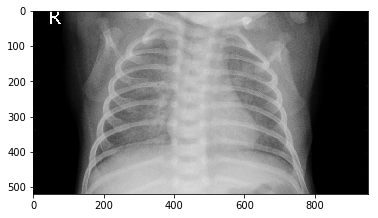

Viral Pneumonia Diagnosed
Inference Latency is : 0.46182775497436523 seconds

In [62]:
import cv2
import matplotlib.pyplot as plt
from torchvision import transforms
import torch
import sys
%matplotlib inline
import time
classes = ['Bacterial Pneumonia Diagnosed', 
           'Pneumonia Not Diagnosed', 
           'Viral Pneumonia Diagnosed']
s_time = time.time()
im = cv2.imread(os.path.join('data/testdir/virus', os.listdir(os.path.join('data/testdir', 'virus'))[60]))
plt.imshow(im)
image_transformer = transforms.Compose([transforms.ToPILImage(), transforms.Resize((224, 224)), transforms.ToTensor()])
im = image_transformer(im)
pred = predictor_aug.predict(im.unsqueeze_(0))
plt.show()
sys.stderr.write(classes[pred.argmax()])
sys.stderr.write("\nInference Latency is : %s seconds" %(time.time() - s_time))

### Implementing the Lambda Function for invoking the API Endpoint.

In [ ]:
import boto3
import json

def lambda_handler(event, context):

    # The SageMaker runtime is what allows us to invoke the endpoint that we've created.
    runtime = boto3.Session().client('sagemaker-runtime')

    # Now we use the SageMaker runtime to invoke our endpoint, sending the review we were given
    response = runtime.invoke_endpoint(EndpointName = 'RealTimeEndPoint-Resnet-2020-04-14-14-35-07',    # The name of the endpoint we created
                                       ContentType = 'application/x-image',  # The data format that is expected in this endpoint
                                       Body = event['body'])                       # The actual review

    # The response is an HTTP response whose body contains the result of our inference
    result = response['Body'].read().decode('utf-8')

    return {
        'statusCode' : 200,
        'headers' : { 'Content-Type' : 'application/json', 'Access-Control-Allow-Origin' : '*' },
        'body' : result
    }

### Cleaning the AWS Account:
We need to clean up all the endpoints that might be running in the background in order not to incur additional charges. So, we delete all the endpoints, empty S3 bucket and stop all the notebook instances.  

In [139]:
predictor.delete_endpoint()

In [34]:
predictor_resnet.delete_endpoint()

In [117]:
predictor_realtime.delete_endpoint()

In [ ]:
predictor_resnet_aug.delete_endpoint()